# NN-VMC with self-attention wave function ansatz

In [1]:
import tqdm
import equinox as eqx
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import optax
import netket as nk
from jaxtyping import Array, PyTree, Float, Complex, PRNGKeyArray

import matplotlib.pyplot as plt

from models.slaternet import SlaterNet
from models.psi_solid import PsiSolid

from systems.continuous import moire
from utils.sampler import metropolis_hastings


key = jax.random.key(42)

c:\workspace\physics\attention-wavefn\atten-wfn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


\begin{equation}
    H=\sum_i\left(-\frac{1}{2}\nabla_i^2 + V(\mathbf r_i)\right) + \sum_{i < j}\frac{1}{|\mathbf r_i-\mathbf r_j|}
\end{equation}
- Moire potential:
\begin{equation}
    V(\mathbf r) = -2V_0\sum_{j=0}^2 \cos(\mathbf g_j\cdot\mathbf r + \varphi)
\end{equation}
Where $\mathbf g_j=\frac{4\pi}{\sqrt{3}a_M}\left(\cos\frac{2\pi j}{3},\sin\frac{2\pi j}{3}\right)$.

- Units
  - mass: Electron mass, $m_e$
  - Length: Effective Bohr radius, $a_0^* = \epsilon\dfrac{m_e}{m^*} a_0$
  - Energy: Effective Hartree, $\mathrm{Ha}^* = \dfrac{1}{\epsilon^2}\dfrac{m^*}{m_e}\mathrm{Ha}$

## System paramerters

In [2]:
# system parameters
a_0 = 5.291_772_105_44e-11 # m
m_e = 9.109_383_7139e-31 # kg
Ha = 4.359_744_722_2060e-18 # J = kg m^2/s^2
meV = 1.60218e-22 # J = kg m^2/s^2
nm = 1e-9 # m


epsilon = 5
# epsilon = 10
m_eff = 0.35 * m_e
a_B_eff = epsilon * (m_e / m_eff) * a_0
Ha_eff = (1 / (epsilon ** 2)) * (m_eff / m_e) * Ha


V0 = 15 * meV / Ha_eff
a_M = 8.031 * nm / a_B_eff
varphi = jnp.pi / 4
(V0, a_M, varphi)

(0.0393743564807352, 10.623473362015782, 0.7853981633974483)

In [3]:
primitive_latt_vects = a_M * jnp.array([
    [jnp.cos(-jnp.pi / 2), jnp.sin(-jnp.pi / 2)],
    [jnp.cos(jnp.pi / 6), jnp.sin(jnp.pi / 6)]
]) # [a_0, a_1]

primitive_recip_latt_vects = ((4 * jnp.pi) / (jnp.sqrt(3) * a_M)) * jnp.array([
    [jnp.cos(-jnp.pi / 3), jnp.sin(-jnp.pi / 3)],
    [jnp.cos(0), jnp.sin(0)]
]) # [b_0, b_1]
# a_i \cdot b_j = 2 \pi \delta_{ij}

(min1, max1) = (-2, 2)
(min2, max2) = (-2, 2)

(minu, maxu) = (min1 + 1/2, max1 + 1/2)
(minv, maxv) = (min2 + 1/2, max2 + 1/2)

N_elec = 16

# parametrization:
u, v = 0.1234, 1.1245
R = u * primitive_latt_vects[0] + v * primitive_latt_vects[1]
def indicator(x):
    u = jnp.dot(primitive_recip_latt_vects[0], x) / (2 * jnp.pi)
    v = jnp.dot(primitive_recip_latt_vects[1], x) / (2 * jnp.pi)
    return (minu <= u) & (u <= maxu) & (minv <= v) & (v <= maxv)

@jax.jit
def N_dim_indicator(R):
    return jnp.all(jax.vmap(indicator)(R))

# super cell: L_x := (max1 - min1) by L_y := (max2 - min2) cell, L_x L_y atoms)
from math import ceil
Nx = ceil(max1 - min1)
Ny = ceil(max2 - min2)
G = jnp.stack([
    primitive_recip_latt_vects[0] / Nx,
    primitive_recip_latt_vects[1] / Ny,
])

## Initializing Models

In [4]:
subkey, key = jax.random.split(key)

slater_wavefn = SlaterNet(
    num_particle=N_elec, 
    recip_latt_vecs=G, 
    hidden_dim=64,
    mlp_depth=8,
    key=subkey,
)

In [5]:
subkey, key = jax.random.split(key)

psi_solid_wavefn = PsiSolid(
    num_particle=N_elec, 
    recip_latt_vecs=G, 
    hidden_dim=64,
    intermediate_dim=64,
    attention_dim=16,
    num_heads=6,
    num_blocks=3, 
    num_mlp_layers=2,
    num_det=4,
    key=subkey,
)

## Samplers

In [6]:
subkey, key = jax.random.split(key)
R0 = jax.random.normal(subkey, (N_elec, 2))
psi_solid_wavefn(R0)

Array(3.82886634e-38+2.86023767e-38j, dtype=complex128)

0.47059998
0.45635986


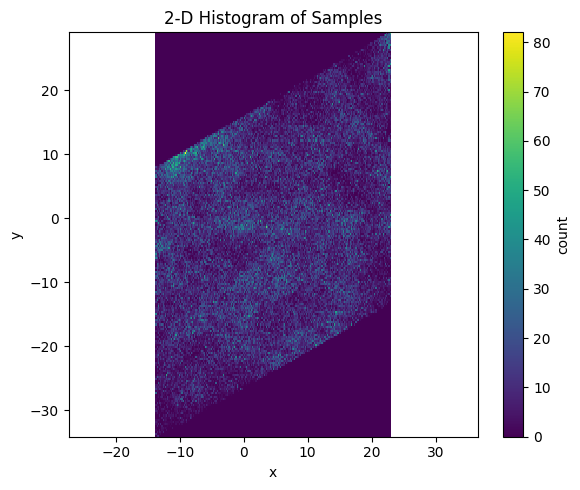

In [7]:
subkey, key = jax.random.split(key)

NDind = lambda x: jnp.all(jax.vmap(indicator)(x))
rho = lambda x: psi_solid_wavefn(x).conj() * psi_solid_wavefn(x)

# burnin
samples, acceptance_rate = metropolis_hastings(
    subkey,
    R0,
    10000,
    0.5,
    NDind, rho
)
R0 = samples[-1]

print(acceptance_rate)

subkey, key = jax.random.split(key)

samples, acceptance_rate = metropolis_hastings(
    subkey,
    R0,
    16384,
    0.5,
    NDind, rho
)
R0 = samples[-1]

print(acceptance_rate)
points = samples.reshape(-1, 2)

plt.figure(figsize=(6, 5))
plt.hist2d(
    points[:, 0],   # x 축
    points[:, 1],   # y 축
    bins=200,             # 격자 수(원하는 해상도로 조정)
    density=False         # 빈도수 그대로 볼 때 False, 확률밀도로 보려면 True
)
plt.colorbar(label='count')  # 각 칸의 샘플 개수 표시
plt.xlabel('x')
plt.ylabel('y')
plt.title('2-D Histogram of Samples')
plt.tight_layout()
plt.axis('equal')
plt.show()

## Train loop

In [ ]:
from jax.profiler import TraceAnnotation
import time

def train(
    wave_fn: eqx.Module,
    optim: optax.GradientTransformation,
    R0: Float[Array, "n_par spc_dim"],
    batch_size: int,
    steps: int,
    key: PRNGKeyArray
):
    opt_state = optim.init(eqx.filter(wave_fn, eqx.is_array))

    energies = np.zeros(steps)
    gradnorms = np.zeros(steps)
    acceptance_rates = np.zeros(steps)
    
    # @eqx.filter_jit
    @jax.profiler.annotate_function
    def make_step(
        wave_fn: eqx.Module,
        opt_state: PyTree,
        R0: Float[Array, "n_par spc_dim"],
        key: PRNGKeyArray
    ):
        with TraceAnnotation("MH_sampling"):
            # MCMC sampling
            samples, acceptance_rate = metropolis_hastings(
                key,
                R0,
                batch_size,
                0.5,
                N_dim_indicator, 
                lambda x: jnp.abs(wave_fn(x).conj() * wave_fn(x))
            )
            R0 = samples[-1]
        
        with TraceAnnotation("local_energy_eval"):
            # local energy
            E_locs = jax.vmap(moire.local_energy,
                            in_axes=(None, 0, None, None, None))(
                wave_fn, samples, V0, a_M, varphi
            ) # (batch,)
            E_locs = jnp.real(E_locs)
                          
        # grad_log_psi_square
        def log_psi_square(wfn, x):
            return jnp.log(jnp.abs(wfn(x).conj() * wfn(x)))

        def grad_log_psi_square(wfn, x):
            return eqx.filter_grad(log_psi_square)(wfn, x)
        
        with TraceAnnotation("grad_log_psi_square"):
            grad_log_psi_squares = jax.vmap(grad_log_psi_square, in_axes=(None, 0))(wave_fn, samples)

        # match mean
        with TraceAnnotation("mean_eval"):
            E_mean = jnp.mean(E_locs)
            grad_log_psi_squares_mean = jax.tree_util.tree_map(lambda g: jnp.mean(g, axis=0), grad_log_psi_squares)
            
        # covariance
        def vmc_cov(g, g_mean):
            centered_g = g - g_mean
            return jnp.einsum('b,b...->...', centered_E, centered_g) / batch_size
        
        with TraceAnnotation("covariance_eval"):
            centered_E = E_locs - E_mean
            grads = jax.tree_util.tree_map(vmc_cov, grad_log_psi_squares, grad_log_psi_squares_mean)
        
        with TraceAnnotation("weight_update"):
            updates, opt_state = optim.update(
                eqx.filter(grads, eqx.is_array), opt_state, eqx.filter(wave_fn, eqx.is_array)
            )
            wave_fn = eqx.apply_updates(wave_fn, updates)
        
        with TraceAnnotation("grad_norm_eval"):
            grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)))
        
        return wave_fn, opt_state, R0, E_mean, grad_norm, acceptance_rate
    
    pbar = tqdm.trange(steps, desc="training", unit="step")
    for step in pbar:
        key, subkey = jax.random.split(key)
        start = time.time()
        with TraceAnnotation("full_make_step"):
            wave_fn, opt_state, R0, energy, grad_norm, acceptance_rate = make_step(wave_fn, opt_state, R0, subkey)
        elapsed = time.time() - start
        print(f"elapsed {elapsed:.4f} sec")
        energies[step] = float(energy)
        gradnorms[step] = float(grad_norm)
        acceptance_rates[step] = float(acceptance_rate)
        pbar.set_postfix(energy=float(energy), gradnorm=float(grad_norm), mh_acc=float(acceptance_rate))
    
    return wave_fn, energies, gradnorms, acceptance_rates

In [9]:
n_batches = 1024
n_steps = 20
start_learning_rate = 1e-3
optim = optax.adam(start_learning_rate)

key, subkey = jax.random.split(key, 2)

with jax.profiler.trace(
        "C:/workspace/physics/attention-wavefn/tmp/jax-trace6",
        create_perfetto_link=False,
        create_perfetto_trace=True):
    wave_fn, energies, gradnorms, acceptance_rates = train(psi_solid_wavefn, optim, R0, n_batches, n_steps, subkey)

training:   5%|▌         | 1/20 [00:56<18:02, 56.99s/step, energy=8.29, gradnorm=8.29, mh_acc=0.5]

elapsed 56.9879 sec


training:  10%|█         | 2/20 [01:51<16:35, 55.29s/step, energy=8.23, gradnorm=8.32, mh_acc=0.474]

elapsed 54.0831 sec


training:  15%|█▌        | 3/20 [02:51<16:16, 57.43s/step, energy=8.85, gradnorm=15.3, mh_acc=0.505]

elapsed 59.9675 sec


training:  20%|██        | 4/20 [03:56<16:08, 60.53s/step, energy=8.24, gradnorm=11.2, mh_acc=0.442]

elapsed 65.2854 sec


training:  25%|██▌       | 5/20 [05:00<15:29, 61.96s/step, energy=8.28, gradnorm=11.2, mh_acc=0.473]

elapsed 64.4785 sec


training:  30%|███       | 6/20 [06:03<14:29, 62.13s/step, energy=8.28, gradnorm=13.3, mh_acc=0.414]

elapsed 62.4537 sec


training:  35%|███▌      | 7/20 [07:08<13:40, 63.11s/step, energy=7.91, gradnorm=15.2, mh_acc=0.357]

elapsed 65.1235 sec


training:  40%|████      | 8/20 [08:12<12:40, 63.38s/step, energy=7.6, gradnorm=5.39, mh_acc=0.429] 

elapsed 63.9405 sec


training:  45%|████▌     | 9/20 [09:16<11:40, 63.64s/step, energy=7.79, gradnorm=6.21, mh_acc=0.411]

elapsed 64.2121 sec


training:  50%|█████     | 10/20 [10:20<10:38, 63.82s/step, energy=7.81, gradnorm=9.33, mh_acc=0.456]

elapsed 64.2153 sec


training:  55%|█████▌    | 11/20 [11:25<09:35, 63.93s/step, energy=8.28, gradnorm=6.85, mh_acc=0.406]

elapsed 64.1892 sec


training:  60%|██████    | 12/20 [12:29<08:33, 64.14s/step, energy=8.14, gradnorm=8.55, mh_acc=0.514]

elapsed 64.6195 sec


training:  65%|██████▌   | 13/20 [13:33<07:28, 64.13s/step, energy=7.3, gradnorm=10, mh_acc=0.466]   

elapsed 64.0776 sec


training:  70%|███████   | 14/20 [14:37<06:24, 64.17s/step, energy=7.5, gradnorm=8.57, mh_acc=0.42]

elapsed 64.2510 sec


training:  75%|███████▌  | 15/20 [15:43<05:22, 64.48s/step, energy=7.6, gradnorm=14.1, mh_acc=0.398]

elapsed 65.2003 sec


training:  80%|████████  | 16/20 [16:48<04:18, 64.64s/step, energy=7.85, gradnorm=9.83, mh_acc=0.389]

elapsed 65.0022 sec


training:  85%|████████▌ | 17/20 [17:53<03:14, 64.80s/step, energy=7.22, gradnorm=7.33, mh_acc=0.42] 

elapsed 65.1610 sec


training:  90%|█████████ | 18/20 [19:07<02:15, 67.50s/step, energy=7.51, gradnorm=9, mh_acc=0.436]  

elapsed 73.7959 sec


training:  95%|█████████▌| 19/20 [20:11<01:06, 66.59s/step, energy=7.59, gradnorm=12.1, mh_acc=0.396]

elapsed 64.4515 sec


training: 100%|██████████| 20/20 [21:15<00:00, 63.79s/step, energy=7.59, gradnorm=10.3, mh_acc=0.482]


elapsed 64.1204 sec


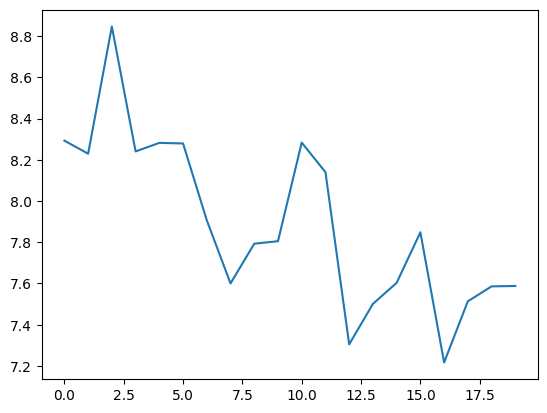

In [10]:
plt.plot(energies)
plt.show()